In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm

from SAMDataset import SAMDataset  # adjust path
from utils import lr_warmup, init_wandb  # if you used that function
from transformers import SamProcessor
from model import FinetunedSAM
import os


/Users/saahilsanganeriya/anaconda3/envs/samcell/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/saahilsanganeriya/anaconda3/envs/samcell/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
def seg_loss_fn(lbl, pred, device):
    """
    Suppose `lbl` shape => (B, 3, H, W), order = (dx, dy, cell_prob).
    Suppose `pred` shape => (B, 3, H, W), same order.

    We do MSE for (dx, dy) and BCE for cell_prob (the 3rd channel).
    """
    # 1) parse out
    dx_gt = lbl[:, 0]  # shape (B,H,W)
    dy_gt = lbl[:, 1]
    cp_gt = lbl[:, 2]  # cellprob => in [0,1] ?

    dx_pred = pred[:, 0]
    dy_pred = pred[:, 1]
    cp_pred = pred[:, 2]

    # 2) define losses
    criterion_mse = nn.MSELoss(reduction='mean')
    criterion_bce = nn.BCEWithLogitsLoss(reduction='mean')

    # MSE on flows
    flows_loss = criterion_mse(dx_pred, 5 * dx_gt) + criterion_mse(dy_pred, 5 * dy_gt)
    # BCE on cellprob
    cp_loss = criterion_bce(cp_pred, cp_gt)

    total_loss = flows_loss + cp_loss
    return total_loss

In [3]:
# 1) Hyperparams
sam_model_path = 'facebook/sam-vit-base'  # your local path
dataset_path = '/project/data/CellPose-train/'
img_path = dataset_path + "imgs.npy"
ann_path = dataset_path + "anns.npy"
flows_path = dataset_path + "flows.npy"  # shape => (N,3,H,W)
weight_path = None  # or your path
output_path = "project/models/samcell_3ch/checkpoints"
num_epochs = 40
batch_size = 2
lr = 1e-4
do_log_wandb = False

# 2) Build the dataset
# e.g. your custom dataset that returns:
#   batch["pixel_values"] => shape [B,3,H_in,W_in] (the input image)
#   batch["ground_truth_mask"] => shape [B,3,H_out,W_out] (the flowsX, flowsY, cellprob)


# For example:
#   processor = ...
#   dataset = SAMDataset(img_path, ann_path, processor=processor)
#   # but in your new pipeline, you might not do the huggingface SamProcessor if you are using SAM2 code?

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")  # or some SAM
# (the transforms are used by your dataset's _preprocess & self.processor calls)
dataset = SAMDataset(
    img_path=img_path,
    flow_path=flows_path,
    ann_path=ann_path,
    processor=processor,
    weight_path=weight_path,
    crop_size=256
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("Loaded dataset with length:", len(dataset))

# 3) Build the model
modelHelper = FinetunedSAM(
    sam_model=sam_model_path,
    finetune_vision=False,
    finetune_prompt=True,
    finetune_decoder=True
)
model = modelHelper.get_model()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.train()

# 4) Build optimizer, etc.
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.1, betas=(0.9, 0.999))
scheduler = LambdaLR(optimizer, lr_lambda=lr_warmup)  # if you want your custom schedule

if do_log_wandb:
    run = init_wandb()

Loaded dataset with length: 540


  0%|          | 0/270 [00:00<?, ?it/s]

ground_truth_flows.shape: torch.Size([2, 3, 256, 256])


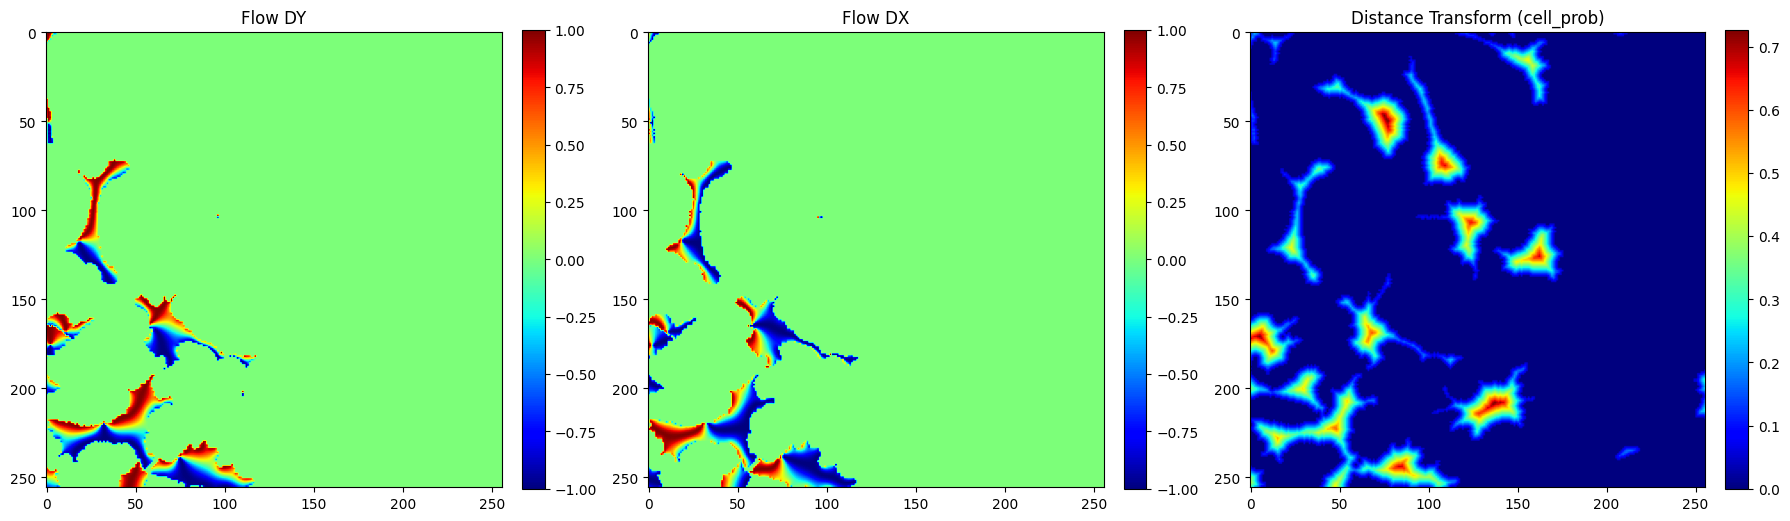

predicted_flows.shape: torch.Size([2, 3, 256, 256])


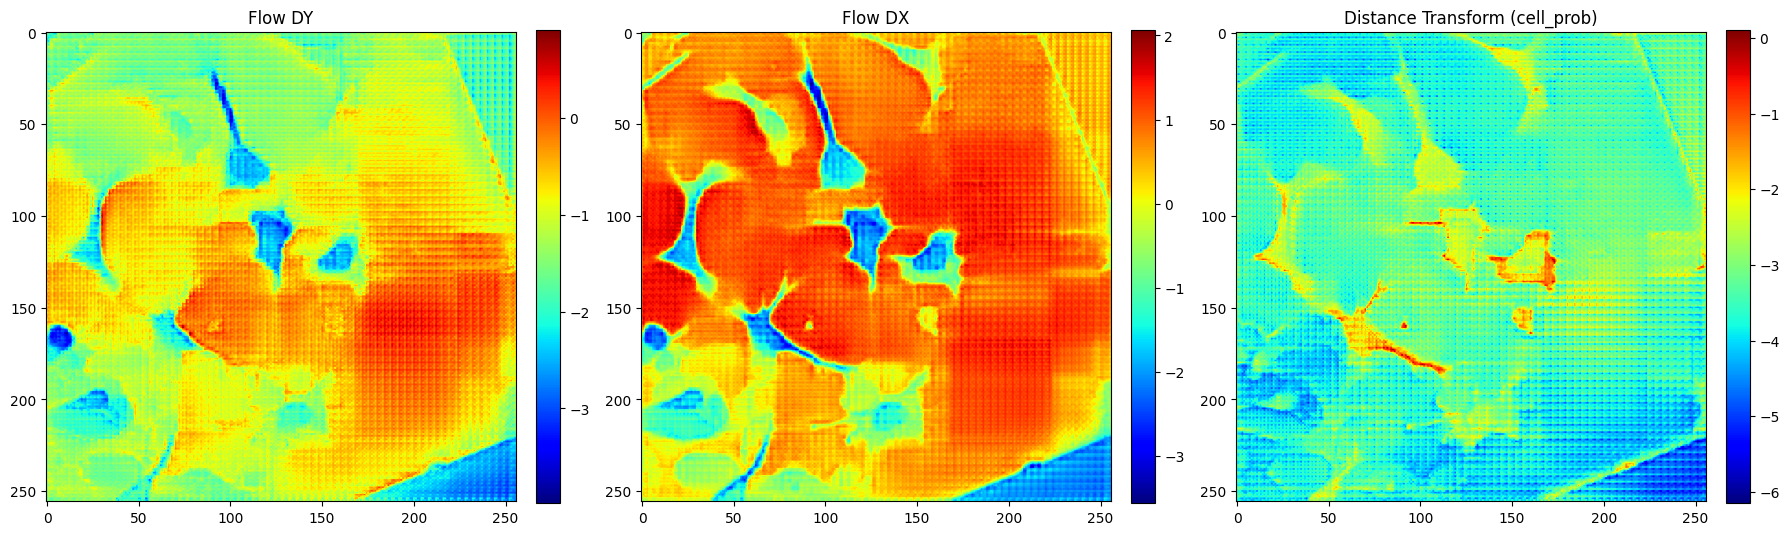

  5%|▌         | 14/270 [01:55<35:18,  8.28s/it]


SystemError: CPUDispatcher(<function _extend_centers at 0x3410b0670>) returned a result with an exception set

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

step = 0
for epoch in range(num_epochs):
    epoch_losses = []
    for batch_data in tqdm(dataloader):
        # batch_data:
        #   batch_data["pixel_values"] => shape [B,3,H_in,W_in]
        #   batch_data["ground_truth_mask"] => shape [B,3,H_out,W_out]
        pixel_values = batch_data["pixel_values"].to(device)

        # forward pass => your SAM2 3Ch
        # The model forward may differ depending on how your code is set up.
        # Possibly something like:
        outputs = model(pixel_values=pixel_values,
                  multimask_output=True)
        # outputs => structure with pred_masks => shape [B, 3, H_out, W_out], presumably

        predicted_flows = outputs.pred_masks.squeeze(1)  # shape => [B, 3, H_out, W_out]
        ground_truth_flows = batch_data["ground_truth_mask"].float().to(device)

        if step % 100 == 0:
            print("ground_truth_flows.shape:", ground_truth_flows.shape)

            # --- Visualize the Flows and Distance Transform ---
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))

            # Flow DY
            im1 = axs[0].imshow(ground_truth_flows[0,1], cmap='jet')
            axs[0].set_title(f"Flow DY")
            plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

            # Flow DX
            im2 = axs[1].imshow(ground_truth_flows[0,0], cmap='jet')
            axs[1].set_title(f"Flow DX")
            plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

            # Distance Transform (cell_prob)
            im3 = axs[2].imshow(ground_truth_flows[0,2], cmap='jet')
            axs[2].set_title(f"Distance Transform (cell_prob)")
            plt.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)

            plt.tight_layout()
            plt.show()

            print("predicted_flows.shape:", predicted_flows.shape)

            # --- Visualize the Flows and Distance Transform ---
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))

            # Flow DY
            im1 = axs[0].imshow(predicted_flows[0,1].detach().cpu().numpy(), cmap='jet')
            axs[0].set_title(f"Flow DY")
            plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

            # Flow DX
            im2 = axs[1].imshow(predicted_flows[0,0].detach().cpu().numpy(), cmap='jet')
            axs[1].set_title(f"Flow DX")
            plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

            # Distance Transform (cell_prob)
            im3 = axs[2].imshow(predicted_flows[0,2].detach().cpu().numpy(), cmap='jet')
            axs[2].set_title(f"Distance Transform (cell_prob)")
            plt.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)

            plt.tight_layout()
            plt.show()


        # compute loss
        loss_val = seg_loss_fn(ground_truth_flows, predicted_flows, device=device)

        # backward pass
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        scheduler.step()

        epoch_losses.append(loss_val.item())
        step += 1

    print(f"[Epoch {epoch}] Loss = {np.mean(epoch_losses):.4f}")

# 6) Save
print("Saving fine-tuned weights to", output_path)
torch.save(model.state_dict(), output_path)